In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/age-gender-and-ethnicity-face-data-csv/age_gender.csv


# Table of content
1. [Importing relevent libraries](#01)
2. [Loading Dataset](#02)
3. [Distributions](#03)
    - [Age Distribution](#3.1)
    - [Ethnicity Distribution](#3.2)
    - [Gender Distribution](#3.3)
    - [Gender Distribution](#3.3)
    - [Sample Images](#3.4)
4. [Model for Gender Prediction](#04)
    - [Spliting data into train/test](#4.1)
    - [Build and train model](#4.2)
    - [Evaluating training history](#4.3)
5. [Model for Ethnicity Prediction](#05)
    - [Spliting data into train/test](#5.1)
    - [Build and train model](#5.2)
    - [Evaluating training history](#5.3)
6. [Model for Age Prediction](#06)
    - [Spliting data into train/test](#6.1)
    - [Build and train model](#6.2)
    - [Evaluating training history](#6.3)

## Importing relevent libraries <a id="01"></a>

In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

## Loading Dataset <a id="02"></a>

In [3]:
data = pd.read_csv('../input/age-gender-and-ethnicity-face-data-csv/age_gender.csv')

## Converting pixels into numpy array
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


In [4]:
print('Total rows: {}'.format(len(data)))
print('Total columns: {}'.format(len(data.columns)))

Total rows: 23705
Total columns: 5


## Distributions <a id="03"></a>

In [5]:
## normalizing pixels data
data['pixels'] = data['pixels'].apply(lambda x: x/255)

## calculating distributions
age_dist = data['age'].value_counts()
ethnicity_dist = data['ethnicity'].value_counts()
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

### Age Distribtion <a id="3.1"></a>

In [6]:
ditribution_plot(x=age_dist.index, y=age_dist.values, name='Age Distribution')

### Ethnicity Distribution <a id="3.2"></a>

In [7]:
ditribution_plot(x=ethnicity_dist.index, y=ethnicity_dist.values, name='Ethnicity Distribution')

### Gender Distribution <a id="3.3"></a>

In [8]:
ditribution_plot(x=gender_dist.index, y=gender_dist.values, name='Gender Distribution')

In [9]:
X = np.array(data['pixels'].tolist())

## Converting pixels from 1D to 3D
X = X.reshape(X.shape[0],48,48,1)

### Sample Images <a id="3.4"></a>

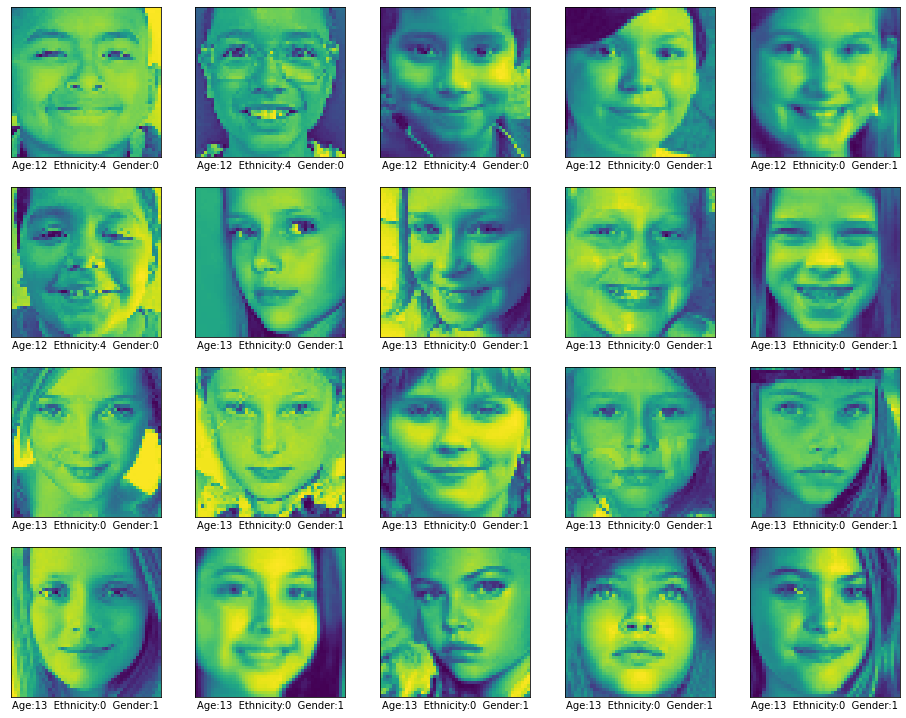

In [10]:
plt.figure(figsize=(16,16))
for i in range(1500,1520):
    plt.subplot(5,5,(i%25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data['pixels'].iloc[i].reshape(48,48))
    plt.xlabel(
        "Age:"+str(data['age'].iloc[i])+
        "  Ethnicity:"+str(data['ethnicity'].iloc[i])+
        "  Gender:"+ str(data['gender'].iloc[i])
    )
plt.show()

 <a id="04"></a>

<h1 class="list-group-item active" style='background:purple; border:0'>
    <center>Model for Gender Prediction</center>
</h1>

### Split data into train/test <a id="4.1"></a>

In [11]:
y = data['gender']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model <a id="4.2"></a>

In [12]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='sigmoid')
])

model.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


## Stop training when validation loss reach 0.2700
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.2700):
            print("\nReached 0.2700 val_loss so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                4

In [13]:
history = model.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/20
260/260 [==============================] - 1s 5ms/step - loss: 0.5172 - accuracy: 0.7414 - val_loss: 0.5977 - val_accuracy: 0.7880
Epoch 2/20
260/260 [==============================] - 1s 4ms/step - loss: 0.3942 - accuracy: 0.8208 - val_loss: 0.4223 - val_accuracy: 0.8378
Epoch 3/20
260/260 [==============================] - 1s 4ms/step - loss: 0.3457 - accuracy: 0.8427 - val_loss: 0.3413 - val_accuracy: 0.8518
Epoch 4/20
260/260 [==============================] - 1s 4ms/step - loss: 0.3229 - accuracy: 0.8549 - val_loss: 0.3173 - val_accuracy: 0.8615
Epoch 5/20
260/260 [==============================] - 1s 4ms/step - loss: 0.3097 - accuracy: 0.8617 - val_loss: 0.3132 - val_accuracy: 0.8632
Epoch 6/20
260/260 [==============================] - 1s 5ms/step - loss: 0.2958 - accuracy: 0.8718 - val_loss: 0.3026 - val_accuracy: 0.8680
Epoch 7/20
260/260 [==============================] - 1s 4ms/step - loss: 0.2825 - accuracy: 0.8729 - val_loss: 0.3086 - val_accuracy: 0.8659
Epoch 

### Evaluate training history <a id="4.3"></a>

In [14]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [15]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.2546588182449341
Test Accuracy: 0.8882285356521606


<a id="05"></a>

<h1 class="list-group-item active" style='background:purple; border:0'>
    <center>Model for Ethnicity Prediction</center>
</h1>

### Split data into train/test <a id="5.1"></a>

In [16]:
y = data['ethnicity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model <a id="5.2"></a>

In [17]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(5)
])

model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


## Stop training when validation accuracy reach 79%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.790):
            print("\nReached 79% val_accuracy so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

In [18]:
history = model.fit(
    X_train, y_train, epochs=16, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/16
260/260 [==============================] - 1s 5ms/step - loss: 1.2402 - accuracy: 0.5258 - val_loss: 0.9810 - val_accuracy: 0.6739
Epoch 2/16
260/260 [==============================] - 1s 4ms/step - loss: 0.9882 - accuracy: 0.6486 - val_loss: 0.8180 - val_accuracy: 0.7107
Epoch 3/16
260/260 [==============================] - 1s 4ms/step - loss: 0.8927 - accuracy: 0.6870 - val_loss: 0.7916 - val_accuracy: 0.7182
Epoch 4/16
260/260 [==============================] - 1s 4ms/step - loss: 0.8327 - accuracy: 0.7118 - val_loss: 0.6986 - val_accuracy: 0.7534
Epoch 5/16
260/260 [==============================] - 1s 4ms/step - loss: 0.7923 - accuracy: 0.7271 - val_loss: 0.6889 - val_accuracy: 0.7572
Epoch 6/16
260/260 [==============================] - 2s 6ms/step - loss: 0.7533 - accuracy: 0.7398 - val_loss: 0.6792 - val_accuracy: 0.7626
Epoch 7/16
260/260 [==============================] - 1s 5ms/step - loss: 0.7179 - accuracy: 0.7512 - val_loss: 0.6415 - val_accuracy: 0.7761
Epoch 

### Evaluate training history <a id="5.3"></a>

In [19]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [20]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.614427924156189
Test Accuracy: 0.793136477470398


<a id="06"></a>

<h1 class="list-group-item active" style='background:orange; border:0'>
    <center>Model for Age prediction</center>
</h1>

### Split data into train/test <a id="6.1"></a>

In [21]:
y = data['age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model <a id="6.2"></a>

In [22]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(128, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='relu')
])

sgd = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])


## Stop training when validation loss reach 110
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<110):
            print("\nReached 110 val_loss so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 128)        

In [23]:
history = model.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/20
260/260 [==============================] - 1s 6ms/step - loss: 354.9518 - mae: 14.2821 - val_loss: 1252.6763 - val_mae: 29.7422
Epoch 2/20
260/260 [==============================] - 1s 5ms/step - loss: 208.5152 - mae: 10.8621 - val_loss: 684.9659 - val_mae: 21.0063
Epoch 3/20
260/260 [==============================] - 1s 5ms/step - loss: 185.6419 - mae: 10.1501 - val_loss: 178.7380 - val_mae: 9.6379
Epoch 4/20
260/260 [==============================] - 1s 5ms/step - loss: 162.7441 - mae: 9.4532 - val_loss: 135.3214 - val_mae: 8.3907
Epoch 5/20
253/260 [============================>.] - ETA: 0s - loss: 148.6607 - mae: 9.0098
Reached 110 val_loss so cancelling training!
260/260 [==============================] - 1s 5ms/step - loss: 148.3461 - mae: 9.0019 - val_loss: 104.4577 - val_mae: 7.5928


### Evaluate training history <a id="6.3"></a> 

In [24]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [25]:
mse, mae = model.evaluate(X_test,y_test,verbose=0)
print('Test Mean squared error: {}'.format(mse))
print('Test Mean absolute error: {}'.format(mae))

Test Mean squared error: 102.4459457397461
Test Mean absolute error: 7.526272773742676


![Alt Text](https://www.kudos.com/assets/Blog/b5843aa89b/thankyou__FillWzcwMCw0NDBd.jpg)